In [41]:
import torch
import torchvision
import cv2
import os
import numpy as np

if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is NOT available on this system.")

CUDA is available on this system.


In [49]:
class ImageComparer:
    """
    Class for comparing images using a image encoder model and cosine similarity.
    """
    def __init__(self, model_path, inference_size=224, device='cuda'):
        """
        Args:
            model_path (str): Path to the model file.
            inference_size (int): Size of the image for inference. The image will be resized to this size before inference.
            device (str): Device to use for inference. Default is 'cuda'.
        """
        self.model_path = model_path
        self.inference_size = inference_size
        self.device = device
        self.model = torch.load(model_path).to(device)
        self.model_dtype = next(self.model.parameters()).dtype
        self.model.eval()
        

    def get_embedding(self, tensor_image):
        """
        Get the embedding of an image.
        Args:
            tensor_image (torch.Tensor): Tensor of shape [c, w, h] representing the image.
        Returns:
            torch.Tensor: Tensor of shape [c, w, h] representing the embedding of the image.
        """
        # Convert the tensor to the model's dtype
        if tensor_image.dtype != self.model_dtype:
            if self.model_dtype == torch.float32:
                tensor_image = tensor_image.float()
            elif self.model_dtype == torch.float16:
                tensor_image = tensor_image.half()
            else:
                raise ValueError(f"Unsupported tensor dtype: {tensor_image.dtype}")
        
        # Resize the image
        c, h, w = tensor_image.shape
        max_dim = max(h, w)
        scale = self.inference_size/max_dim
        resize_img = torchvision.transforms.Resize((int(h*scale), int(w*scale)), antialias=False)
        tensor_image = resize_img(tensor_image)

        # Get the embedding
        with torch.no_grad():
            embedding = self.model(tensor_image.unsqueeze(0)).squeeze(0)
            
        return embedding


    def get_cosine_similarity_matrix(self, embedding1, embedding2):
        """
        Get the cosine similarity matrix of two embeddings.
        Args:
            embedding1 (torch.Tensor): Tensor of shape [c, w, h] representing the first embedding.
            embedding2 (torch.Tensor): Tensor of shape [c, w, h] representing the second embedding.
        Returns:
            torch.Tensor: Tensor of shape [w, h] representing the cosine similarity matrix.
        """
        # Check the shapes
        if embedding1.shape != embedding2.shape:
            raise ValueError("Embeddings must have the same shape")
        if len(embedding1.shape) != 3:
            raise ValueError("Embeddings must have 3 dimensions, [c, w, h]")
        c, w, h = embedding1.shape

        # Reshape the embeddings to 2D tensors where each row is a vector from the original 3D tensors
        embedding1_reshaped = embedding1.permute(1, 2, 0).reshape(-1, embedding1.shape[0])
        embedding2_reshaped = embedding2.permute(1, 2, 0).reshape(-1, embedding2.shape[0])

        # Compute the cosine similarity
        similarity_matrix = torch.nn.functional.cosine_similarity(embedding1_reshaped, embedding2_reshaped, dim=1)

        # Reshape the similarity matrix back to the original shape
        similarity_matrix = similarity_matrix.reshape(w, h)
        
        return similarity_matrix


    def get_cosine_similarity(self, embedding1, embedding2):
        """
        Get the cosine similarity of two embeddings.
        Args:
            embedding1 (torch.Tensor): Tensor of shape [c, w, h] representing the first embedding.
            embedding2 (torch.Tensor): Tensor of shape [c, w, h] representing the second embedding.
        Returns:
            float: The cosine similarity of the two embeddings.
        """
        cossim_matrix = self.get_cosine_similarity_matrix(embedding1, embedding2)
        return cossim_matrix.sum()/cossim_matrix.numel()


    def compare(self, tensor_image1, tensor_image2):
        """
        Compare two images.
        Args:
            tensor_image1 (torch.Tensor): Tensor of shape [c, w, h] representing the first image.
            tensor_image2 (torch.Tensor): Tensor of shape [c, w, h] representing the second image.
        Returns:
            float: The cosine similarity of the two images.
        """
        embedding1 = self.get_embedding(tensor_image1)
        embedding2 = self.get_embedding(tensor_image2)
        return self.get_cosine_similarity(embedding1, embedding2)
    
    def preprocess_image(self, image_path):
        """
        Preprocess an image for comparison.
        Args:
            image_path (str): Path to the image file.
        Returns:
            torch.Tensor: Tensor of shape [c, w, h] representing the image.
        """
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torchvision.transforms.ToTensor()(image).to(self.device)
        return image
        

In [97]:
# create the image comparer
model_path = "models/resnet18_encoder_ds16.pt"
image_comparer = ImageComparer(model_path, inference_size=2560)

In [98]:
folder_path = "data/new_york"

# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".png")]

#Sort by file name ascending
image_files = sorted(image_files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0][-1:]))

In [99]:
num_images = len(image_files)
similarity_matrix = np.zeros((num_images, num_images))

# Calculate embeddings for all images
embeddings = []
for image_file in image_files:
    image_tensor = image_comparer.preprocess_image(image_file)
    embedding =image_comparer.get_embedding(image_tensor)
    embeddings.append(embedding)

In [100]:
# Create a dictionary to store the cosine similarity matrices
cossim_matrices = {}

# Calculate similarity scores and populate the matrix
for i in range(num_images):
    for j in range(i, num_images):
        embedding1 = embeddings[i]
        embedding2 = embeddings[j]
        
        cossim_matrix = image_comparer.get_cosine_similarity_matrix(embedding1, embedding2)
        similarity_score = cossim_matrix.sum() / cossim_matrix.numel()
        
        # Save cossim matrix to dictionary
        cossim_matrices[(i, j)] = cossim_matrix


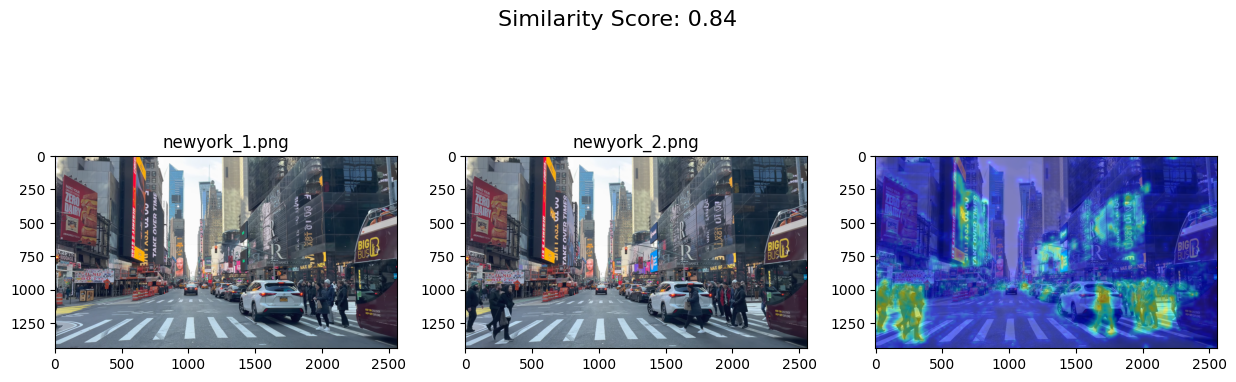

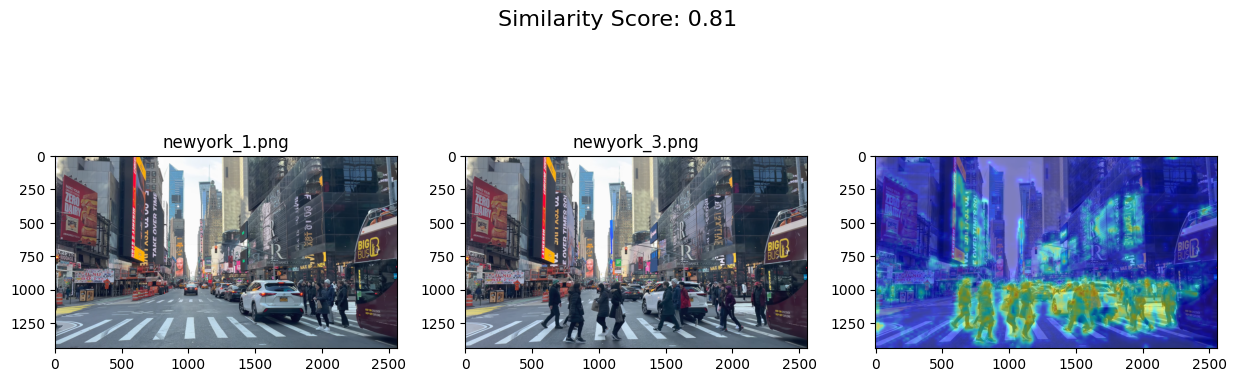

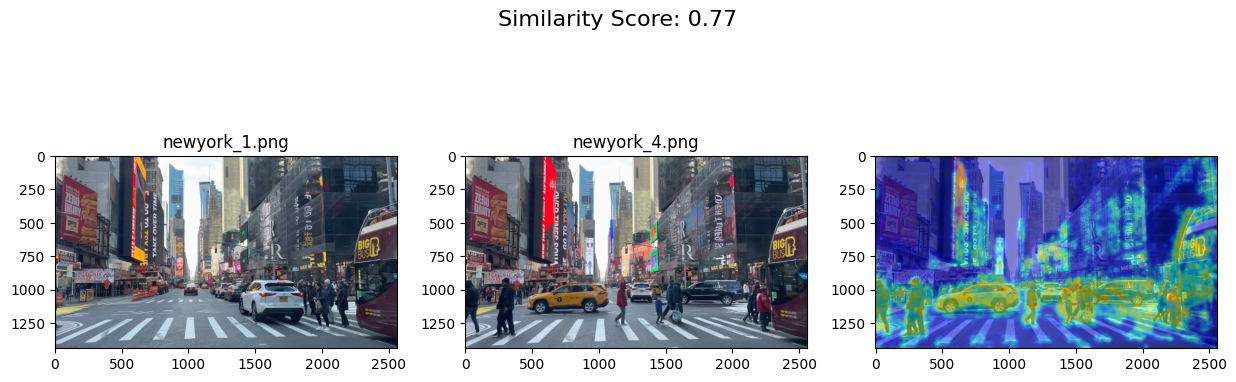

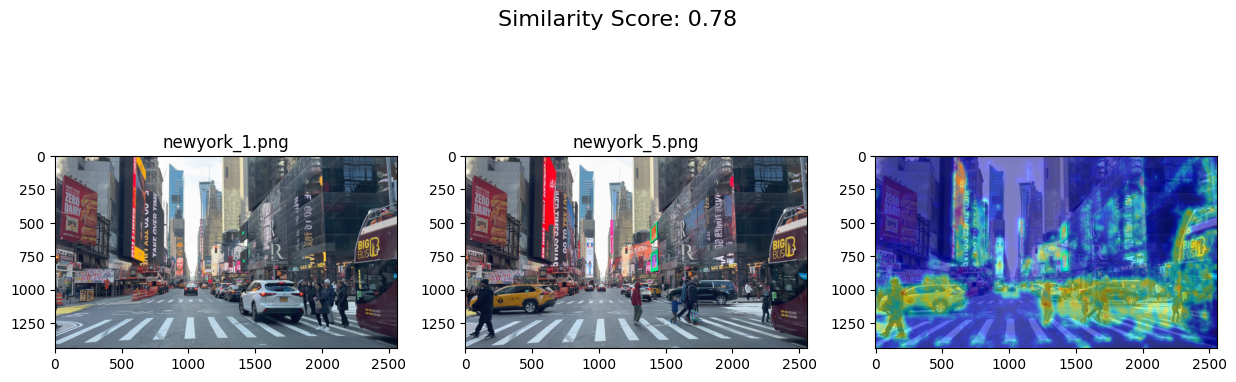

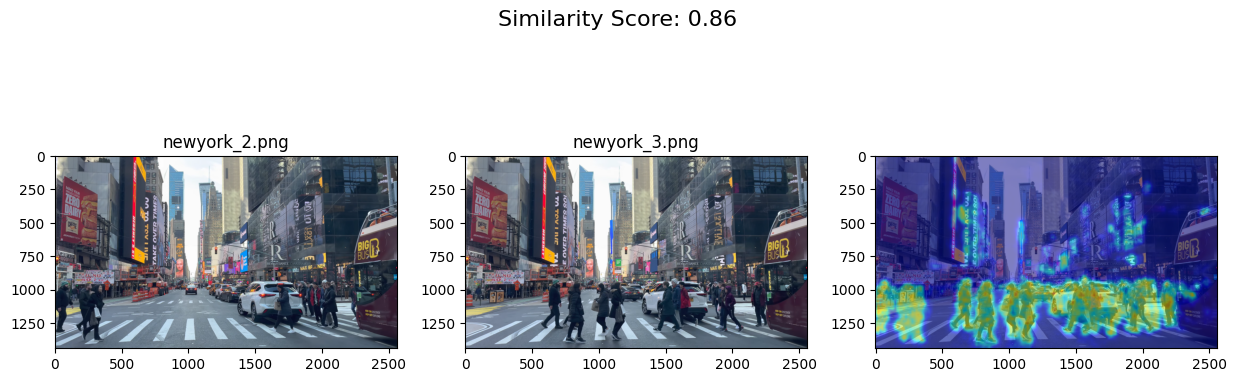

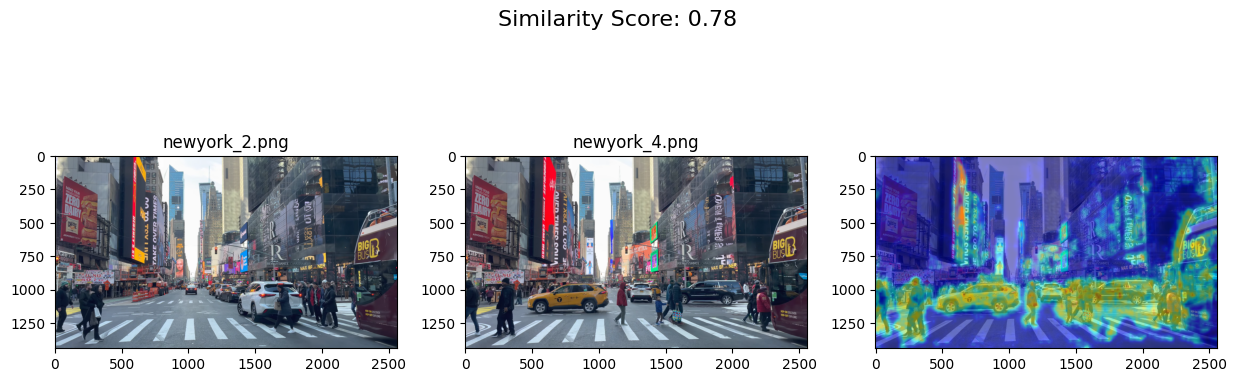

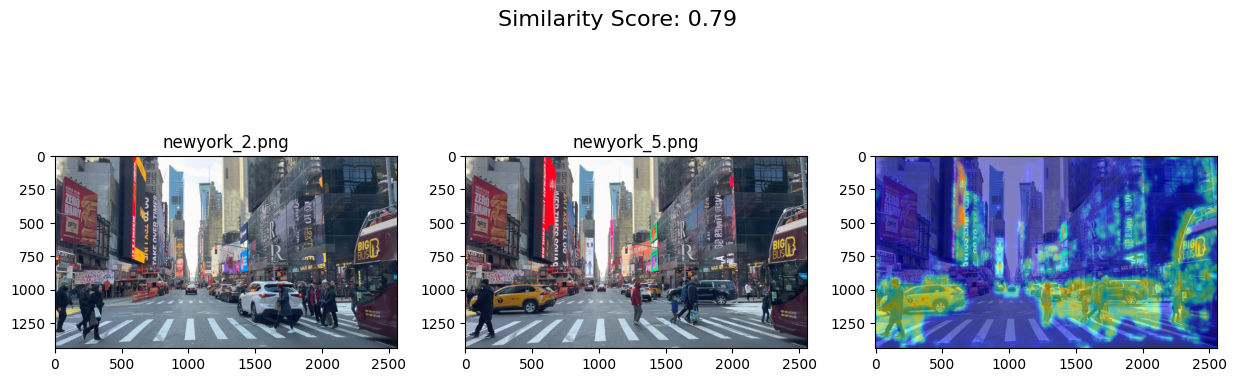

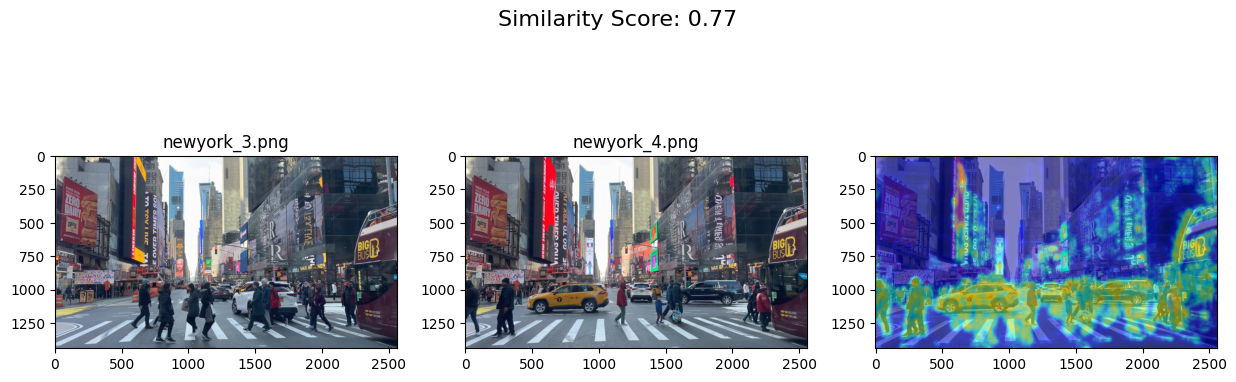

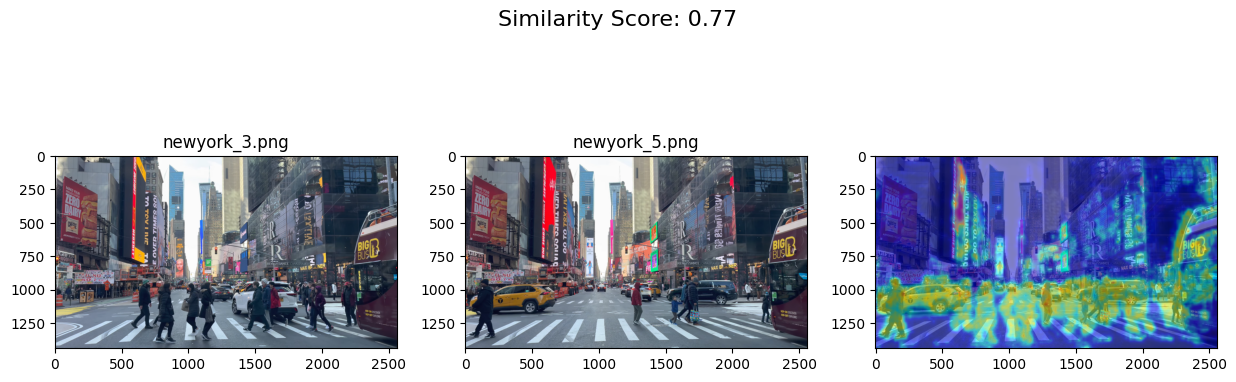

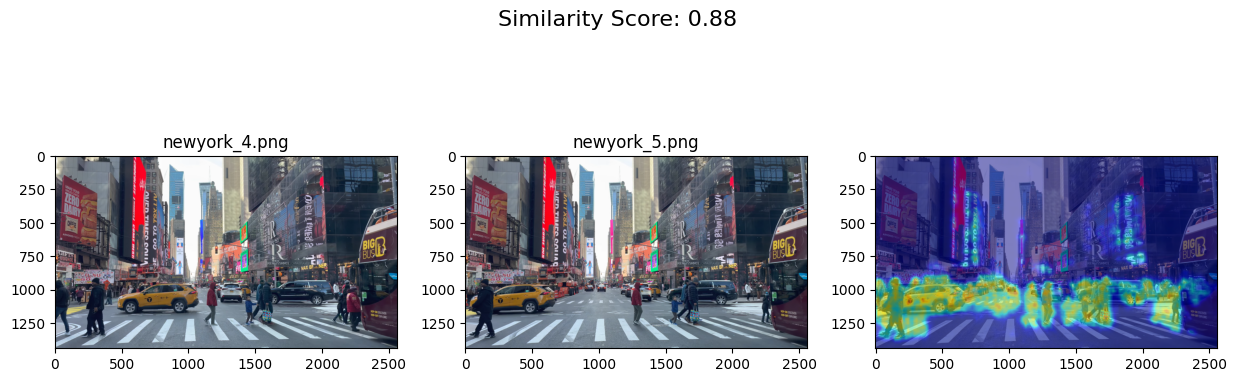

In [101]:
import matplotlib.pyplot as plt
import cv2

# Define a function to plot image pairs
def plot_image_pairs(image_files, cossim_matrices):
    """
    Plots image pairs along with their similarity score and heatmap where red indicates dissimilarity and blue indicates similarity.
    
    Args:
        image_files: list of image file paths
        cossim_matrices: dictionary of cosine similarity matrices

    """
    num_images = len(image_files)
    
    # Iterate through each image pair and plot them along with their similarity score
    for i in range(num_images):
    #for i in range(1):
        for j in range(i + 1, num_images):
            img1_path = image_files[i]
            img2_path = image_files[j]
            
            img1 = cv2.imread(img1_path)
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2 = cv2.imread(img2_path)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
            
            # Add heatmap to the image
            similarity_matrix_ij = cossim_matrices[(i, j)]
            similarity_score = similarity_matrix_ij.sum() / similarity_matrix_ij.numel()
            similarity_matrix_ij = similarity_matrix_ij.cpu().numpy()
            #similarity_matrix_ij = similarity_matrix_ij / similarity_matrix_ij.max()
            similarity_matrix_ij = (similarity_matrix_ij) * 255
            similarity_matrix_ij = similarity_matrix_ij.astype(np.uint8)
            similarity_matrix_ij = cv2.resize(similarity_matrix_ij, (img1.shape[1], img1.shape[0]))
            similarity_matrix_ij = cv2.applyColorMap(similarity_matrix_ij, cv2.COLORMAP_JET)
            img3 = cv2.addWeighted(img2, 0.5, similarity_matrix_ij, 0.5, 0)

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(img1)
            plt.title(os.path.basename(img1_path))

            plt.subplot(1, 3, 2)
            plt.imshow(img2)
            plt.title(os.path.basename(img2_path))

            plt.subplot(1, 3, 3)
            plt.imshow(img3)

            
            plt.suptitle(f'Similarity Score: {similarity_score:.2f}', fontsize=16)
            
            plt.show()

# Call the function to plot image pairs
plot_image_pairs(image_files, cossim_matrices)

